# Motocycle Night Ride
---
## 데이터 셋

### Kaggle Motorcycle Night Ride


In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

image shape: (1080, 1920, 4)


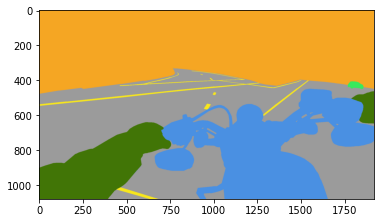

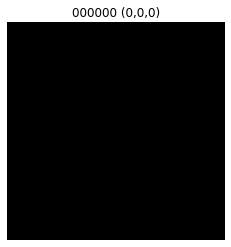

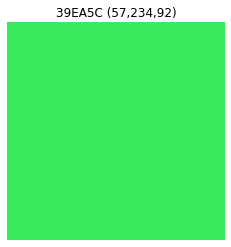

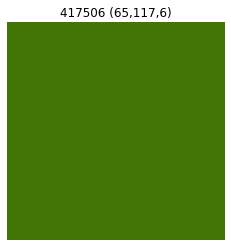

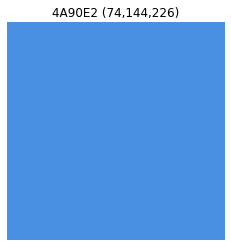

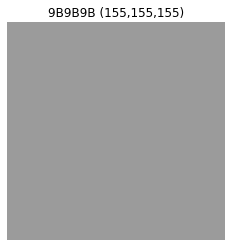

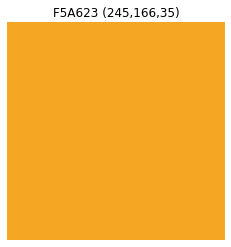

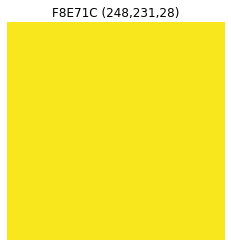

In [2]:
# label 이미지 파일 경로 list
dir_path = './data/images' # Kaggle 에서 다운로드 받은 파일 내 images 폴더 경로   

label_images = glob(os.path.join(dir_path, "night ride (*).png___fuse.png"))

# sample 이미지 확인
output_path = label_images[0]
_output = imread(output_path)
print('image shape:', _output.shape)

# 알파 채널 제거
if _output.shape[2] == 4:
    output = _output[:,:,:_output.shape[2]-1]

# 이미지로부터 컬러 확인
def rgb_to_hex(red, green, blue):
    return "{:02X}{:02X}{:02X}".format(red, green, blue)

def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

height,width,channels = output.shape
undefined_color = rgb_to_hex(0,0,0)
color_set = set([undefined_color])
for h in range(height):
    for w in range(width):        
        r,g,b = output[h,w]
        color_set.add(rgb_to_hex(r,g,b))

color_list = list(color_set)
color_list.sort()

plt.imshow(output)
plt.show()
for hex_color in color_list:
    r,g,b = hex_to_rgb(hex_color)
    color_text = f'{hex_color} ({r},{g},{b})'
    cbox = np.ones((1, 1, 3), dtype=np.uint8) * 255
    cbox[0:1, 0:1] = [r,g,b]
    plt.imshow(cbox)
    plt.title(color_text)
    plt.axis('off')  # 축 숨기기
    plt.show()       

In [3]:
#  LABEL_NAME = {
#     '000000': 'Undefined', 
#     '39EA5C': 'Movable', 
#     '417506': 'Rider', 
#     '4A90E2': 'My bike', 
#     '9B9B9B': 'Road', 
#     'F5A623': 'Undrivable', 
#     'F8E71C': 'Lanemark'
# }    
LABEL_HEX = [
    '000000',
    '39EA5C',
    '417506',
    '4A90E2',
    '9B9B9B',
    'F5A623',
    'F8E71C'
]
def rgb_to_hex(red, green, blue):
    return "{:02X}{:02X}{:02X}".format(red, green, blue)

def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_label(r,g,b):    
    try :
        return LABEL_HEX.index(rgb_to_hex(r,g,b))
    except:
        return 0
    
def label_to_rgb(label):
    try :
        return hex_to_rgb(LABEL_HEX[label])
    except:
        return (0, 0, 0)

# 3채널(rgb) 이미지를 1채널(label) 이미지로 변환
def get_target(mask):
    height, width, channels = mask.shape
    target = np.zeros((height, width, 1), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            r,g,b = mask[h,w]
            target[h, w, 0] = rgb_to_label(r,g,b)
    return target

# 1채널(label)이미지를 3채널(rgb)이미지로 변환
def get_mask(target):
    height, width, channels = target.shape
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            label = int(target[h,w,0])
            r,g,b = label_to_rgb(label)
            mask[h, w, 0] = r
            mask[h, w, 1] = g
            mask[h, w, 2] = b
    return mask

In [4]:
###################################################################################
# Augumetation
###################################################################################
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
#             RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
#                 min_max_height=(300, 370),
#                 w2h_ratio=370/1242,
#                 height=224,
#                 width=224,
#                 p=0.5
#             ),
            Resize(              # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
        )
    ])

In [5]:
###################################################################################
# CustomGenerator
###################################################################################
class CustomGenerator(tf.keras.utils.Sequence):    
    '''
    CustomGenerator tf.keras.utils.Sequence를 상속받습니다.
    '''    
    def __init__(self, 
                 data_loader,
                 batch_size=5,
                 img_size=(224, 224, 3),
                 output_size=(224, 224, 1),
                 is_train=True,
                 augmentation=None):        
        '''
        data_loader: dataset의 파일 경로를 받아오는 함수
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # data_loader()을 통해서 라벨과 이미지를 확인
        self.data = data_loader(is_train)
        
    def __len__(self):
        # Generator의 전체 길이를 반환 함수 
        # 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 "올림"한 값 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # index값에 따라 데이터를 반환하는 함수
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            #-----------------------------------------------
            # augmentation >>> build_augmentation 함수 변경시 확인 필요
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)            
            _input = augmented["image"]
            _output = augmented["mask"]
            
            #-----------------------------------------------
            # 알파 채널 제거
            if _input.shape[2] == 4:
                _input = _input[:,:,:_input.shape[2]-1]
            if _output.shape[2] == 4:
                _output = _output[:,:,:_output.shape[2]-1]                                    
            #-----------------------------------------------            
            # inputs normalization
            # outputs 이미지 변환 rgb(,,3) >>> label(,,1)
            inputs[i] = _input / 255
            outputs[i] = get_target(_output)
            #-----------------------------------------------
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

###################################################################################
def load_motorcycle(is_train = False):
    # Motorcycle Night Ride dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    
    dir_path = './data/images' # 다운로드 받은 데이터 셋의 images 폴더 경로
        
    input_images = glob(os.path.join(dir_path, "night ride (*).png"))
    label_images = glob(os.path.join(dir_path, "night ride (*).png___fuse.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]
    if is_train:
        return data[:-30]
    return data[-30:]

augmentation = build_augmentation()
train_generator = CustomGenerator(
    load_motorcycle, 
    augmentation=augmentation,
)
test_preproc = build_augmentation(is_train=False)
test_generator = CustomGenerator(
    load_motorcycle, 
    augmentation=test_preproc,
    is_train=False
)

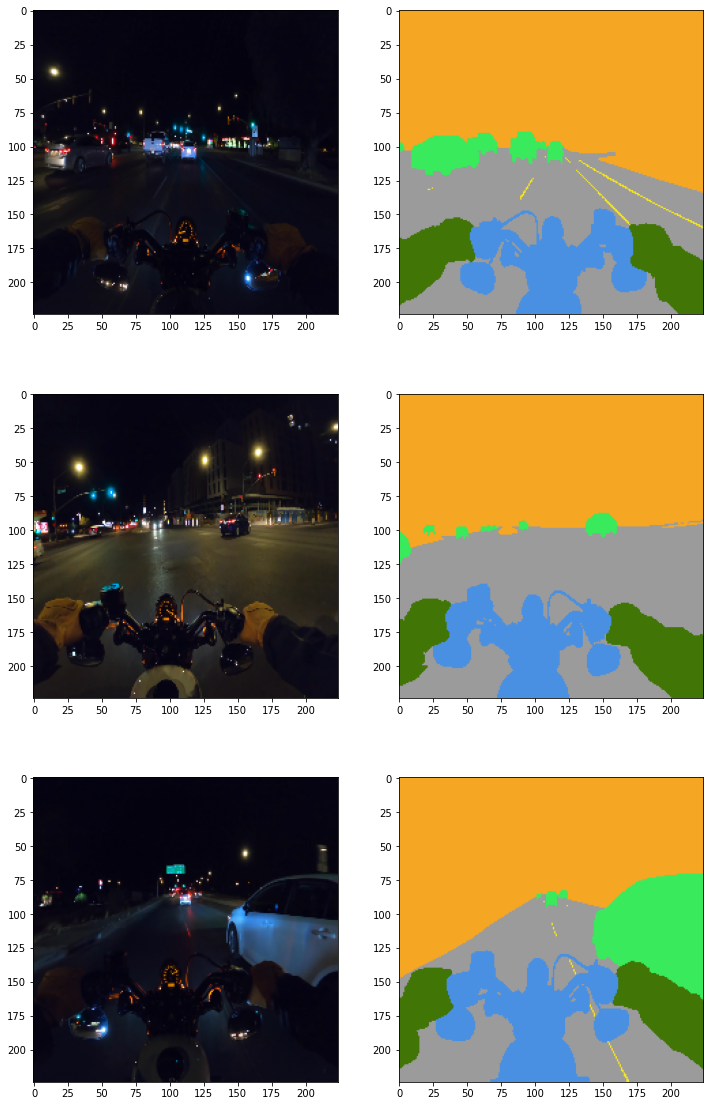

In [6]:
def show_data(generator, show_num=3):
    inputs, outputs = generator.__getitem__(0)
    plt.figure(figsize=(12, 20))
    for i in range(show_num):
        plt.subplot(show_num, 2, 2*i+1)
        plt.imshow(inputs[i] )
        plt.subplot(show_num, 2, 2*i+2)
        #-----------------------------------------------
        # output 이미지 변환  label(,,1) >>> rgb(,,3)
        _output = get_mask(outputs[i])
        #-----------------------------------------------
        plt.imshow(_output)
    plt.show()
show_data(train_generator)

---
## U-Net++ 모델

In [12]:
#########################################################################################
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def down_sampling(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    x = conv_block(x, num_filters)
    return x, MaxPooling2D((2, 2))(x)

def up_sampling(inputs, skips, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()(skips + [x])
    x = conv_block(x, num_filters)
    return conv_block(x, num_filters)
#########################################################################################
# build_model
#########################################################################################
def build_model(input_shape=(224, 224, 3), num_classes=1, is_plus=False, deep_supervision=False):    
    fsize=[64,128,256,512,1024]
#     fsize=[32,64,128,256,512]
    
    inputs = Input(shape=input_shape)
    
    x00, x = down_sampling(inputs, fsize[0])
    x10, x = down_sampling(x, fsize[1])
    x20, x = down_sampling(x, fsize[2])
    x30, x = down_sampling(x, fsize[3])
    x40, x = down_sampling(x, fsize[4])
    
    model_name='U-Net'
    act = 'sigmoid' if num_classes > 1 else 'softmax'
    
    if is_plus:
        x01 = up_sampling(x10, [x00], fsize[0])
        x11 = up_sampling(x20, [x10], fsize[1])
        x21 = up_sampling(x30, [x20], fsize[2])
        x31 = up_sampling(x40, [x30], fsize[3])

        x02 = up_sampling(x11, [x00, x01], fsize[0])
        x12 = up_sampling(x21, [x10, x11], fsize[1])
        x22 = up_sampling(x31, [x20, x21], fsize[2])

        x03 = up_sampling(x12, [x00, x01, x02], fsize[0])
        x13 = up_sampling(x22, [x10, x11, x12], fsize[1])

        x04 = up_sampling(x13, [x00, x01, x02, x03], fsize[0])
        
        x1 = Conv2D(num_classes, 1, padding='same', activation=act)(x01)
        x2 = Conv2D(num_classes, 1, padding='same', activation=act)(x02)
        x3 = Conv2D(num_classes, 1, padding='same', activation=act)(x03)
        x4 = Conv2D(num_classes, 1, padding='same', activation=act)(x04)

        model_name='U-Net_Plus'
        x = [x4]

        if deep_supervision:        
            model_name='U-Net_Plus_Deep_Supervision'
            x = [x1, x2, x3, x4]
        
    else:
        x31 = up_sampling(x40, [x30], fsize[3])
        x22 = up_sampling(x31, [x20], fsize[2])
        x13 = up_sampling(x22, [x10], fsize[1])
        x04 = up_sampling(x13, [x00], fsize[0])
        
        x = Conv2D(num_classes, 1, padding='same', activation=act)(x04)
        
    return Model(inputs=inputs, outputs=x, name=model_name)
    
    
#########################################################################################
# 모델 컴파일
#########################################################################################
from tensorflow.keras import backend

# Dice Coefficient
# def dice_coef(y_true, y_pred):
#     smooth = 1.
#     y_true_f = backend.flatten(y_true)
#     y_pred_f = backend.flatten(y_pred)
#     intersection = backend.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
#
# def bce_dice_loss(y_true, y_pred):
#     return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
#
# def compile_model(model):
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(1e-4),
#         loss=bce_dice_loss,
#         metrics=["binary_crossentropy", dice_coef]
#     )
#     model.summary()
#     return model;

def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    model.summary()
    return model;
#########################################################################################
# 모델 훈련
#########################################################################################
import pickle
def fit_model(model):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch=len(train_generator),
        epochs=5
    )    
    m_path = f'./model_{model.name}.h5'
    model.save(m_path)  #학습한 모델을 저장

    h_path = f'./history_{model.name}.pkl'
    with open(h_path, 'wb') as file:
        pickle.dump(history.history, file)
    return model, history

In [ ]:
# 모델 학습
num_classes = len(LABEL_HEX)
unet, h_unet = fit_model(compile_model(build_model(num_classes=num_classes)))

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 224, 224, 64) 256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 224, 224, 64) 0           batch_normalization_18[0][0]     
______________________________________________________________________________________________

NameError: name 'h_unet_pp' is not defined

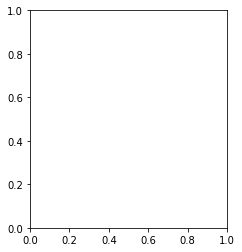

In [10]:
plt.figure(figsize=(12, 4))

# train, validation loss graph
plt.subplot(1, 3, 1)
plt.plot(h_unet_pp.history['accuracy'])
plt.plot(h_unet_pp.history['val_accuracy'])
plt.title(f'{unet_pp.name}')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

# plt.subplot(1, 3, 2)
# plt.plot(h_m2.history['loss'])
# plt.plot(h_m2.history['val_loss'])
# plt.title(f'{m2.name}')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'val'], loc='upper right')

# plt.subplot(1, 3, 3)
# plt.plot(h_m3.history['loss'])
# plt.plot(h_m3.history['val_loss'])
# plt.title(f'{m3.name}')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'val'], loc='upper right')

plt.show()